In this **you will implement the following:**
1. GAN / LSGAN loss functions and training code for MNIST dataset.
2. Train GAN / LSGAN on CelebA dataset with DCGAN architecture.


### Colab Setup: 
- Below are some basic steps for colab setup. 
- Make changes based on requirements.
- Comment out in case of ARC or your local device with powerful GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
# modify "path_to_project", path of folder in drive, where you uploaded your homework files
path_to_project = "/content/drive/My Drive/Deep Learning/"
sys.path.append(path_to_project)

# Section 1. Generative Adversarial Networks on MNIST Dataset

In this section, you will need to:
1. Implement two different types of loss functions (GAN / LSGAN) for generative adversarial networks. 
2. Build the Discriminator and Generator.
3. Implement training codes for your GAN models.
3. Train your model on MNIST dataset and visualize the generated images.

Now, let's get started!

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)

In [ ]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Section 1.1. Vanilla GAN loss functions

### Section 1.1.1 GAN Loss
We start from implementing the vanilla GAN loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). Specifically, you need to complete the `generator_loss` and `discriminator_loss` in the cell below.

Recalled from the class, the generator loss is written as:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these equations could be silghtly different from what we have seen before. This is because that in Pytorch, our optimize will be *minimizing* the loss functions. As a result, we negate the formulas to match pytorch's behavior.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
 
    loss = None
    target_real = torch.ones_like(logits_real, dtype=torch.float).to(device)
    target_fake = torch.zeros_like(logits_fake, dtype=torch.float).to(device)
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    discriminator_loss_real = nn.functional.binary_cross_entropy_with_logits(logits_real, target_real)
    discriminator_loss_fake = nn.functional.binary_cross_entropy_with_logits(logits_fake, target_fake)
    loss = (discriminator_loss_real + discriminator_loss_fake)/2
    ##########       END      ##########
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    loss = None
    target_real = torch.ones_like(logits_fake, dtype=torch.float).to(device)
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, target_real)
    ##########       END      ##########
    return loss

### Section 1.1.2 Build simple model

Build your simple model using below layers:

**Discriminator:**

- Flatten input (flatten the C x H x W into a single vector per image)
- linear (784, 256)
- Leaky ReLU ()
- Linear(256, 256)
- Leaky ReLU()
- Linear(256, 1)

**Generator:**
- Linear(noise_dim, 1024)
- ReLU()
- Linear(1024, 1024)
- ReLU()
- linear(1024, 784)
- Tanh()

In [ ]:
NOISE_DIM = 100

def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    # Your code here:
    model = nn.Sequential(nn.Flatten(),
                          nn.Linear(in_features=784, out_features=256),
                          nn.LeakyReLU(),
                          nn.Linear(in_features=256, out_features=256),
                          nn.LeakyReLU(),
                          nn.Linear(in_features=256, out_features=1)        
                          )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    # Your code here:
    model = nn.Sequential(nn.Linear(in_features=noise_dim, out_features=1024),
                          nn.ReLU(),
                          nn.Linear(in_features=1024, out_features=1024),
                          nn.ReLU(),
                          nn.Linear(in_features=1024, out_features=784),
                          nn.Tanh()        
                          )
    return model

### Section 1.1.3 Training code
You can't train a model without a proper training code. Implement the GAN training procedure here following the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) and the course slides in the cell below. Note that this code would be reused in the subsequent section, so make sure that it is correctly implemented.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
          ckpt_dir = path_to_project + '/ckpts/Vanilla_gan_MINST/', cont_train=False,
          batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.

    The loop will consist of two steps: a discriminator step and a generator step.

    (1) In the discriminator step, you should zero gradients in the discriminator
    and sample noise to generate a fake data batch using the generator. Flatten real images 
    to 784 (28 * 28). Calculate the discriminator output for real and fake data, 
    and use the output to compute discriminator loss. Call backward() on the loss 
    output and take an optimizer step for the discriminator.

    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.

    You will need to reshape the fake image tensor outputted by the generator to
    be dimensions (batch_size x input_channels x img_size x img_size).

    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    if os.path.exists(os.path.join(ckpt_dir, 'checkpoint.pth')) and cont_train:
        ckpt = torch.load(os.path.join(ckpt_dir, 'checkpoint.pth'))
        start_epoch = ckpt['epoch'] + 1
        iter_count = ckpt['iter_count'] + 1
        G.load_state_dict(ckpt['G'])
        D.load_state_dict(ckpt['D'])
        print('Start from a checkpoint: {}, epoch:{}, iter:{}'.format(os.path.join(ckpt_dir, 'checkpoint.pth'), 
                                                 str(start_epoch), str(iter_count)))
    else:
        start_epoch = 0
        iter_count = 0
        
    for epoch in range(start_epoch, num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            batch, input_channels, img_size, _ = x.shape

            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None


            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################
            D.zero_grad()

            fake_data = noise(batch_size=batch_size, dim=noise_size).to(device)
            fake_images = G(fake_data)

            discriminator_real = D(real_images)
            discriminator_fake = D(fake_images)

            d_error = discriminator_loss(discriminator_real, discriminator_fake)
            d_error.backward()
            D_solver.step()
            #########       END      ###########
 
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################
            G.zero_grad()

            fake_data = noise(batch_size=batch_size, dim=noise_size).to(device)
            fake_images = G(fake_data)
            discriminator_fake = D(fake_images)
            g_error = generator_loss(discriminator_fake)

            g_error.backward()
            G_solver.step()            
            ##########       END      ##########

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1
            
        # save checkpoints
        os.makedirs(ckpt_dir, exist_ok=True)
        print('Saving the model as a checkpoint...')
        torch.save({'epoch': epoch, 
                    'iter_count': iter_count,
                    'G': G.state_dict(), 
                    'D': D.state_dict()}, 
                   os.path.join(ckpt_dir, 'checkpoint.pth'))

MNIST is a simple dataset that contains one hand-written digit in each image. It is usually used for sanity check. So, let's test our loss functions and training code on it!

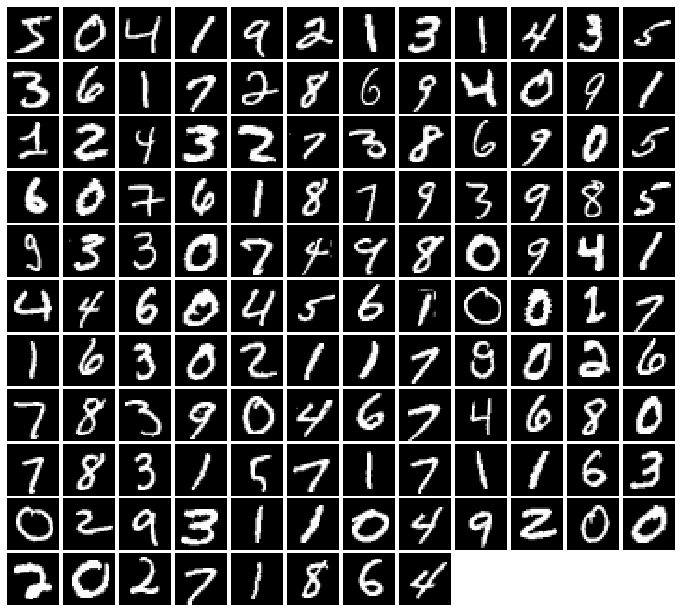

In [ ]:
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

### Section 1.1.4 Train your model

- Call Discriminator and Generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with lr=1e-3, betas = (0.5, 0.999))
- Call train function to train. 
- Train for 10 epochs.

After training your GAN model, you should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="https://drive.google.com/uc?export=view&id=1ynz9z9xlzw_y2WTg2qfhSH55tCsmdDcj" width=300><br>
Refer mnist.jpg from gan_samples folder.

EPOCH:  1
Iter: 0, D: 0.7049, G:0.7066


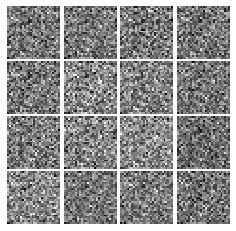


Iter: 250, D: 0.4966, G:0.7768


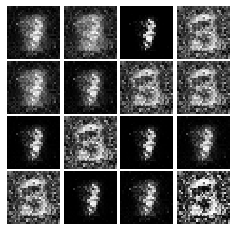


Saving the model as a checkpoint...
EPOCH:  2
Iter: 500, D: 0.6499, G:0.6241


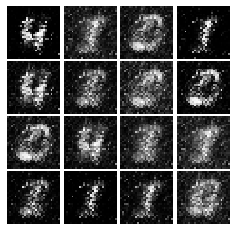


Iter: 750, D: 0.5423, G:1.4


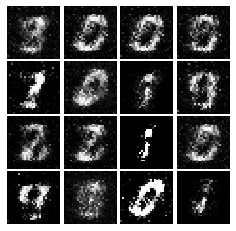


Saving the model as a checkpoint...
EPOCH:  3
Iter: 1000, D: 0.537, G:0.7054


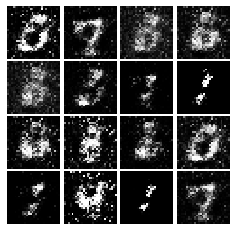


Iter: 1250, D: 0.5118, G:0.9988


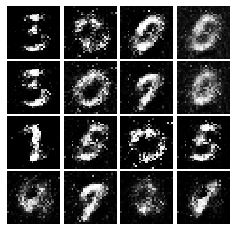


Saving the model as a checkpoint...
EPOCH:  4
Iter: 1500, D: 0.6188, G:1.142


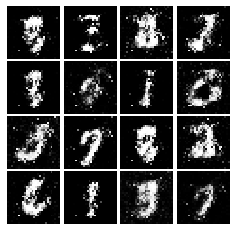


Iter: 1750, D: 0.5979, G:0.3387


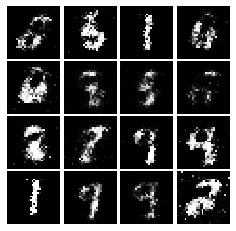


Saving the model as a checkpoint...
EPOCH:  5
Iter: 2000, D: 0.5868, G:0.8663


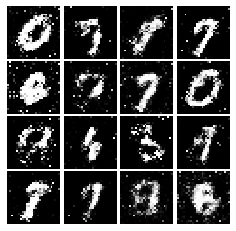


Iter: 2250, D: 0.6304, G:1.168


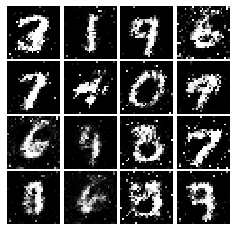


Saving the model as a checkpoint...
EPOCH:  6
Iter: 2500, D: 0.6715, G:0.9154


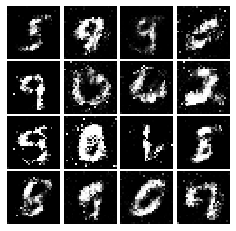


Iter: 2750, D: 0.6384, G:1.026


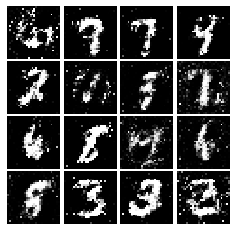


Saving the model as a checkpoint...
EPOCH:  7
Iter: 3000, D: 0.6245, G:0.9054


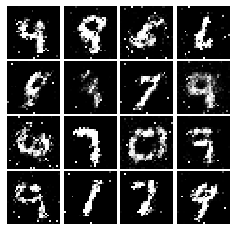


Iter: 3250, D: 0.5965, G:0.9977


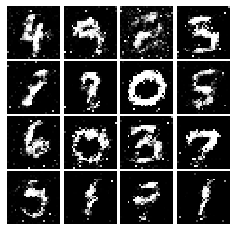


Saving the model as a checkpoint...
EPOCH:  8
Iter: 3500, D: 0.6095, G:0.8769


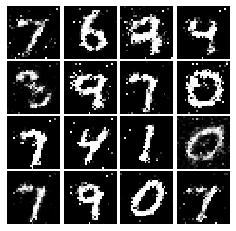


Saving the model as a checkpoint...
EPOCH:  9
Iter: 3750, D: 0.6921, G:0.849


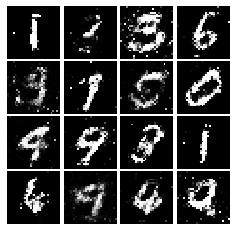


Iter: 4000, D: 0.6338, G:0.8102


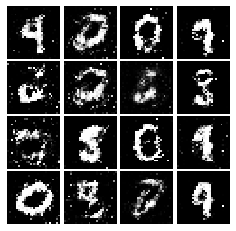


Saving the model as a checkpoint...
EPOCH:  10
Iter: 4250, D: 0.631, G:0.8025


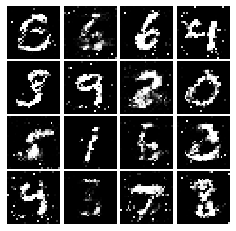


Iter: 4500, D: 0.6798, G:0.8425


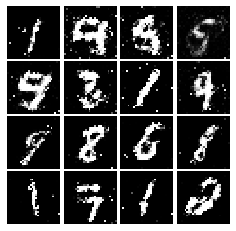


Saving the model as a checkpoint...


In [ ]:
# Add training code here:
D = discriminator().to(device)
G = generator().to(device)
lr = 1e-3
D_solver = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))

train(D=D, G=G, D_solver=D_solver, G_solver=G_solver, discriminator_loss=discriminator_loss, generator_loss=generator_loss, train_loader=loader_train, device=device)

## Section 1.2 Least-square GAN Loss
### Section 1.2.1 LSGAN Loss
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Fill in the `ls_discriminator_loss` and `ls_generator_loss` in the cell below.

**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [ ]:
def ls_discriminator_loss(logits_real, logits_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    
    loss = None
    target_real = torch.ones_like(logits_real, dtype=torch.float).to(device)
    target_fake = torch.zeros_like(logits_fake, dtype=torch.float).to(device)
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    discriminator_loss_real = torch.nn.functional.mse_loss(logits_real, target_real)
    discriminator_loss_fake = torch.nn.functional.mse_loss(logits_fake, target_fake)
    loss = (discriminator_loss_real + discriminator_loss_fake)/2
    ##########       END      ##########
    return loss

def ls_generator_loss(logits_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
 
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    
    loss = None
    target_real = torch.ones_like(logits_fake, dtype=torch.float).to(device)
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = torch.nn.functional.mse_loss(logits_fake, target_real)
    ##########       END      ##########
    return loss    

### Section 1.2.2 Train model with LSGAN loss

- Call Discriminator and Generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with lr=1e-3, betas = (0.5, 0.999))
- Call train function to train. 
- Train for 10 epochs.

Similarly, train your LSGAN on MNIST dataset. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="https://drive.google.com/uc?export=view&id=1lCvFA2hcELBNCngpa921noHNMhNVhaVR" width=300><br>

EPOCH:  1
Iter: 0, D: 0.4533, G:0.8832


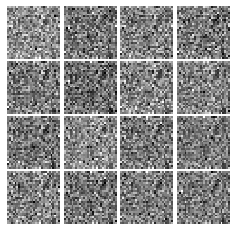


Iter: 250, D: 0.4596, G:0.6435


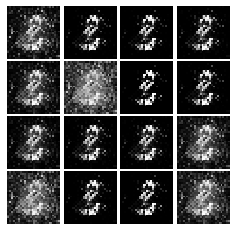


Saving the model as a checkpoint...
EPOCH:  2
Iter: 500, D: 0.09936, G:0.742


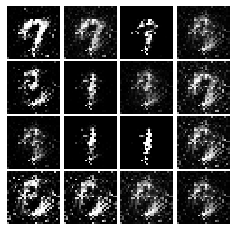


Iter: 750, D: 0.1511, G:0.7143


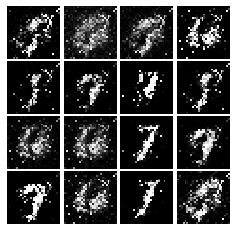


Saving the model as a checkpoint...
EPOCH:  3
Iter: 1000, D: 0.2568, G:0.8306


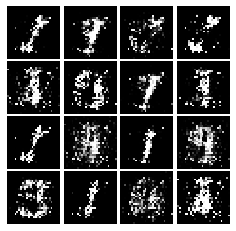


Iter: 1250, D: 0.1557, G:0.5509


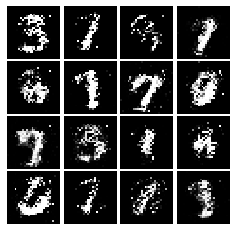


Saving the model as a checkpoint...
EPOCH:  4
Iter: 1500, D: 0.2049, G:0.362


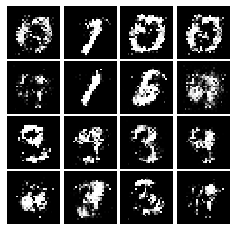


Iter: 1750, D: 0.3259, G:0.8789


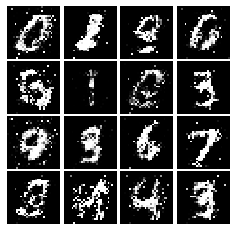


Saving the model as a checkpoint...
EPOCH:  5
Iter: 2000, D: 0.2186, G:0.4171


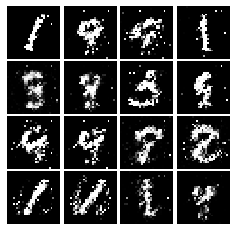


Iter: 2250, D: 0.2131, G:0.3973


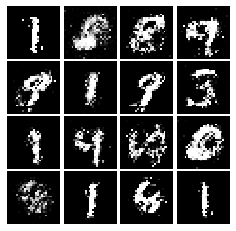


Saving the model as a checkpoint...
EPOCH:  6
Iter: 2500, D: 0.2338, G:0.4141


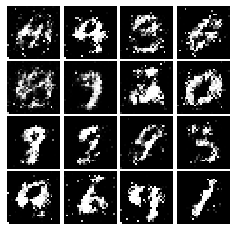


Iter: 2750, D: 0.2177, G:0.354


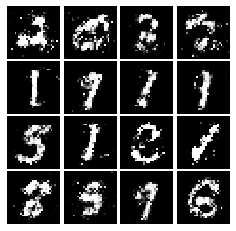


Saving the model as a checkpoint...
EPOCH:  7
Iter: 3000, D: 0.2224, G:0.3117


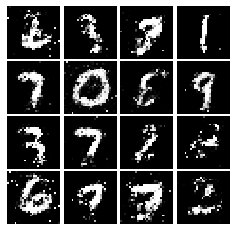


Iter: 3250, D: 0.2184, G:0.3613


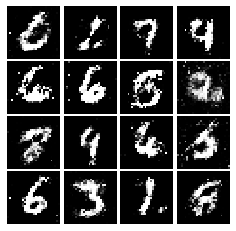


Saving the model as a checkpoint...
EPOCH:  8
Iter: 3500, D: 0.2399, G:0.3404


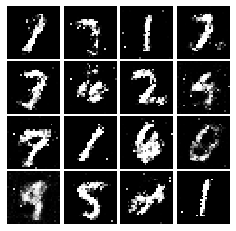


Saving the model as a checkpoint...
EPOCH:  9
Iter: 3750, D: 0.2179, G:0.3531


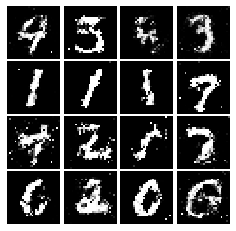


Iter: 4000, D: 0.2529, G:0.2971


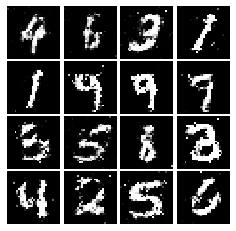


Saving the model as a checkpoint...
EPOCH:  10
Iter: 4250, D: 0.234, G:0.3769


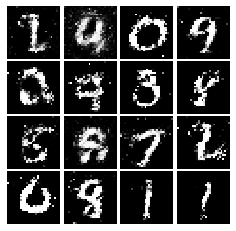


Iter: 4500, D: 0.249, G:0.3387


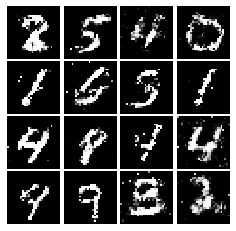


Saving the model as a checkpoint...


In [ ]:
# YOUR TRAINING CODE HERE
D = discriminator().to(device)
G = generator().to(device)
lr = 1e-3
D_solver = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))

train(D=D, G=G, D_solver=D_solver, G_solver=G_solver, discriminator_loss=ls_discriminator_loss, generator_loss=ls_generator_loss, train_loader=loader_train, device=device)

# Section 2. Generative Adversarial Networks on CelebA Dataset

In this section, you will need to:
1. Implement DCGAN architecture
2. Train it on CelebA dataset.

We are done with the simple, not-so-challenging MNIST dataset. Now, you need to implement a specific model architecture called [DCGAN](https://arxiv.org/pdf/1511.06434.pdf), and train your model to generate human faces!

### Section 2.1. GAN model architecture

Implement your generator and discriminator for generating faces. We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):
**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2, padding=1
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2, padding=1
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2, padding=1
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2, padding=1
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1, padding=0

Instead of Relu we use LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). 

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1, padding=0
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2, padding=1
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2, padding=1
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2, padding=1
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2, padding=1

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [ ]:
# YOUR GENERATOR/DISCRIMINATOR HERE
from torchsummary import summary
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    # Your code here:
    model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
                          nn.LeakyReLU(negative_slope=0.2),
                          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),                          
                          nn.BatchNorm2d(num_features=256),
                          nn.LeakyReLU(negative_slope=0.2),
                          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
                          nn.BatchNorm2d(num_features=512),
                          nn.LeakyReLU(negative_slope=0.2),
                          nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
                          nn.BatchNorm2d(num_features=1024),
                          nn.LeakyReLU(negative_slope=0.2),
                          nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
                          nn.LeakyReLU(negative_slope=0.2)      
                          )
    return model

def generator(noise_dim=100):
    """
    Initialize and return a simple generator model.
    """
    # Your code here:
    model = nn.Sequential(nn.ConvTranspose2d(in_channels=NOISE_DIM, out_channels=1024, kernel_size=4, stride=1, padding=0),
                          nn.BatchNorm2d(num_features=1024),
                          nn.ReLU(),
                          nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
                          nn.BatchNorm2d(num_features=512),
                          nn.ReLU(),
                          nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
                          nn.BatchNorm2d(num_features=256),
                          nn.ReLU(),
                          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2,  padding=1),
                          nn.BatchNorm2d(num_features=128),
                          nn.ReLU(),
                          nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
                          nn.Tanh()        
                          )
    return model

### Section 2.2 Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

Run download_celeba.sh to get dataset.

In [ ]:
!wget https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
!mkdir celeba_data
!unzip q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip -d celeba_data
!rm q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip

In [ ]:
import sys
sys.path, dirs, files = next(os.walk("/content/celeba_data/celeba_train_128res"))
file_count = len(files)
print(file_count)

126252


In [ ]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = "/content/celeba_data"

In [ ]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

# You can change the num_workers to speed up loading
celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True, num_workers=4)

#### Visualize dataset

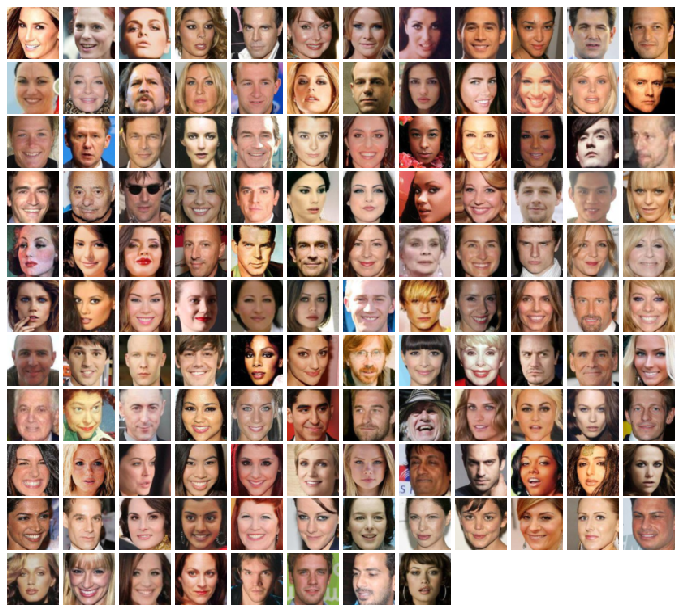

In [ ]:
imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

### Section 2.3 Train a Vanilla GAN on CelebA

- Call discriminator and generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with betas = (0.5, 0.999))
- Call train function to train. 
- Train for 30 epochs.

Now, train your GAN model with vanilla GAN loss. If you models are implemented correctly, you should see something like this:
<img src="https://drive.google.com/uc?export=view&id=1gHPxOt8w-G0W15RyBfeabgN_xauWiArD" width=300><br>

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 30
learning_rate = 0.0002

In [ ]:
def noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim, 1, 1))
    return to_return/torch.max(to_return)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
          ckpt_dir = path_to_project + '/ckpts/gan_celib/', cont_train=False,
          batch_size=128, noise_size=100, num_epochs=30, train_loader=None, device=None):
    
    if os.path.exists(os.path.join(ckpt_dir, 'checkpoint.pth')) and cont_train:
        ckpt = torch.load(os.path.join(ckpt_dir, 'checkpoint.pth'))
        start_epoch = ckpt['epoch'] + 1
        iter_count = ckpt['iter_count'] + 1
        G.load_state_dict(ckpt['G'])
        D.load_state_dict(ckpt['D'])
        print('Start from a checkpoint: {}, epoch:{}, iter:{}'.format(os.path.join(ckpt_dir, 'checkpoint.pth'), 
                                                 str(start_epoch), str(iter_count)))
    else:
        start_epoch = 0
        iter_count = 0
        
    for epoch in range(start_epoch, num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            batch, input_channels, img_size, _ = x.shape       

            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None

            torch.cuda.empty_cache()
            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################
            D.zero_grad()

            fake_data = noise(batch_size=batch_size, dim=noise_size).to(device)   
            # print("fake data", fake_data.shape)         
            fake_images = G(fake_data)
            # print("fake image", fake_images.shape)

            discriminator_real = D(real_images)
            discriminator_fake = D(fake_images)

            d_error = discriminator_loss(discriminator_real, discriminator_fake)
            d_error.backward()
            D_solver.step()
            #########       END      ###########

            torch.cuda.empty_cache()
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################
            G.zero_grad()

            fake_data = noise(batch_size=batch_size, dim=noise_size).to(device)
            fake_images = G(fake_data)
            discriminator_fake = D(fake_images)
            g_error = generator_loss(discriminator_fake)

            g_error.backward()
            G_solver.step()            
            ##########       END      ##########

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1
            
        # save checkpoints
        os.makedirs(ckpt_dir, exist_ok=True)
        print('Saving the model as a checkpoint...')
        torch.save({'epoch': epoch, 
                    'iter_count': iter_count,
                    'G': G.state_dict(), 
                    'D': D.state_dict()}, 
                   os.path.join(ckpt_dir, 'checkpoint.pth'))

In [ ]:
# original GAN
# Add code here:
torch.cuda.empty_cache()
D = discriminator().to(device)
G = generator(noise_dim=NOISE_DIM).to(device)
D_solver = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5, 0.999))

train(D=D, G=G, D_solver=D_solver, G_solver=G_solver, discriminator_loss=discriminator_loss, generator_loss=generator_loss, train_loader=celeba_loader_train, device=device, batch_size=128)

Output hidden; open in https://colab.research.google.com to view.

### Section 2.4 Train a LSGAN on CelebA

- Call discriminator and generator for training.
- Call optimizers for both discriminator and generator for training. (Use Adam with betas = (0.5, 0.999))
- Call train function to train. 
- Train for 30 epochs.

In [ ]:
# LSGAN
# Add code here:
torch.cuda.empty_cache()
D = discriminator().to(device)
G = generator(noise_dim=NOISE_DIM).to(device)
D_solver = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5, 0.999))

train(D=D, G=G, D_solver=D_solver, G_solver=G_solver, discriminator_loss=ls_discriminator_loss, generator_loss=ls_generator_loss, train_loader=celeba_loader_train, device=device, batch_size=128)




Output hidden; open in https://colab.research.google.com to view.